# Implement the DQN algorithm on the Pong environment
This assignment implements Deep Q-Network (DQN) in the Pong environment, using the game screen as the state and a CNN for Q-value approximation.

## Flow chart
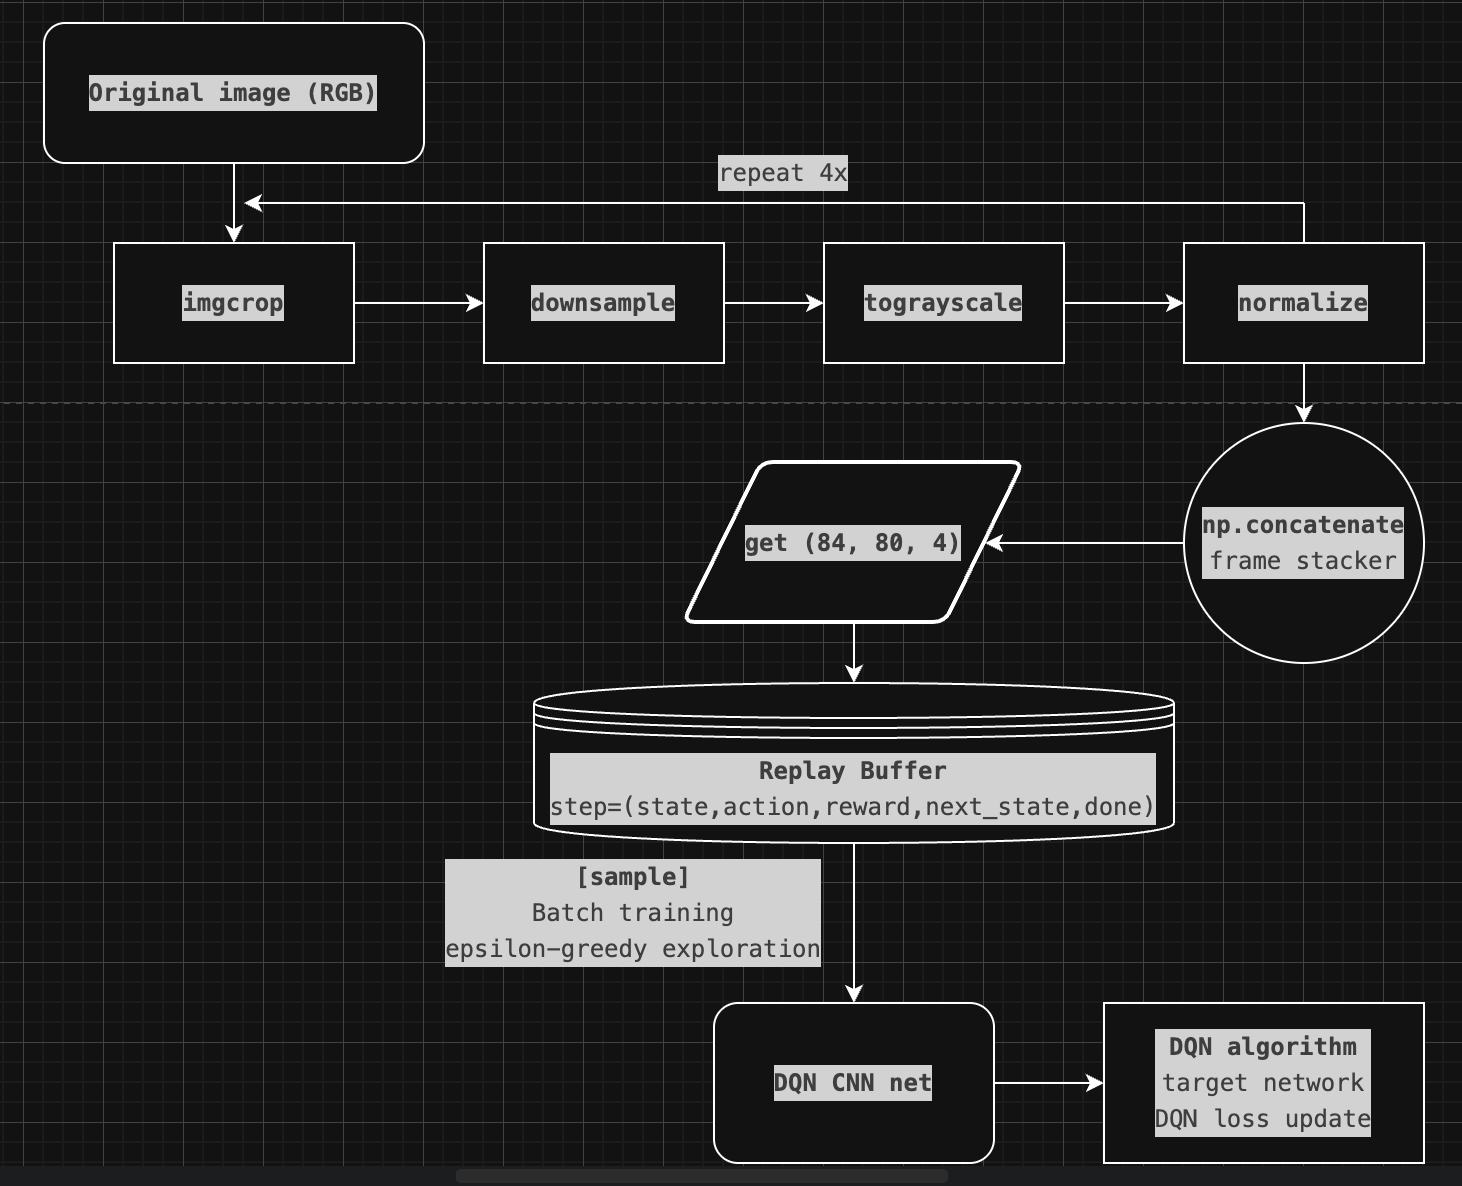

## Environment description
Because the Farama Foundation gymnasium has not yet released an Atari environment, the system environment cannot use "PongDeterministic-v4". Technically, gym[atari] and "PongNoFrameskip-v4" are used as alternatives.

DQN, CNN, and assignment3_utils.py are all implemented according to the textbook standard. 

## Set Up Environment
Install libraries in terminal as follows:
- gymnasium[atari]
- gym[atari]
- numpy 
- torch 
- matplotlib
- autorom 

In [147]:
# Pong environment initialization
import gym
env = gym.make("PongNoFrameskip-v4")

## Preprocessing tool integration
Load assignment3_utils.py and define a frame stacker (to record 4 consecutive frames as input to the CNN)

### Preprocessing steps of assignment3_utils.py
- `imgcrop`: Remove top and bottom black borders
- `downsample`: Downsample and reduce dimensionality
- `tograyscale`: Convert RGB to grayscale
- `normalizegrayscale`: Normalize grayscale pixels to [-1, 1]
- `processframe`: Complete the above steps and reshape to a shape usable by the CNN

### Define function 
- `stack_frames`: Stack 4 processed frames as CNN input (state)

---

### State preprocessing and stacking process
1. Original RGB image cropped → downsampled → grayscale → normalized to [-1, 1].
2. Four consecutive frames stacked into shape [84, 80, 4].
3. Used as input to CNN to extract dynamic environment features.

In [148]:
# Improt necessary library
from assignment3_utils import process_frame

# Define a frame stacker
def stack_frames(frames, new_frame, img_shape):
    processed_frame = process_frame(new_frame, img_shape)  # shape (84,80,1)
    # If the processed_frame has an additional batch [1,84,80,1], then squeeze
    pf = np.squeeze(processed_frame)
    # squeeze only removes the dimension with size=1, ensuring the result is (84,80,1)
    if pf.ndim == 2:  # If all channels are squeezed out
        pf = np.expand_dims(pf, axis=2)  # (84,80,1)
    frames.append(pf)
    
    while len(frames) < 4:
        frames.append(pf.copy())
    if len(frames) > 4:
        frames.pop(0)
    
    # concatenate to form (84,80,4)
    stacked = np.concatenate(frames, axis=2)
    return stacked, frames

# Establish DQN network architecture
## CNN network architecture (input is 84x80x4, 4 frames are stitched together)
- CNN Structure (input shape: [batch, 4, 84, 80])
    - Conv2d(4, 32, kernel_size=8, stride=4) → ReLU
    - Conv2d(32, 64, kernel_size=4, stride=2) → ReLU
    - Conv2d(64, 64, kernel_size=3, stride=1) → ReLU
    - Flatten → Linear (512) → ReLU → Linear (out: number of actions)
    
- The network can automatically adapt to the input dimension (flattening dimension calculation is performed on dummy data).
- CNNs directly extract features from images and support high-dimensional continuous state spaces.

In [149]:
# Import libraries
import torch
import torch.nn as nn

# Define DQN network
class DQN(nn.Module):
    def __init__(self, input_shape, num_actions):
        super(DQN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(4, 32, kernel_size=8, stride=4),  # 4 stacked grayscale frames
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Flatten(),
        )
        with torch.no_grad():
            dummy = torch.zeros(1, *input_shape)
            n_flatten = self.conv(dummy).shape[1]
        self.fc = nn.Sequential(
            nn.Linear(n_flatten, 512),
            nn.ReLU(),
            nn.Linear(512, num_actions)
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        return x

## Define Replay Buffer function 
`ReplayBuffer`: Stores (s, a, r, s', done) in a first-in-first-out manner. During sampling, `np.stack` ensures the shape is (B, 84, 80, 4)

In [150]:
# Import libraries
from collections import deque
import random
import numpy as np

# Define Replay Buffer
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, done):
        self.buffer.append((np.array(state), action, reward, np.array(next_state), done))
    
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        states = np.stack(states, axis=0) # shape (B,84,80,4)
        actions = np.array(actions)
        rewards = np.array(rewards)
        next_states = np.stack(next_states, axis=0)
        dones = np.array(dones)
        return states, actions, rewards, next_states, dones
    
    def __len__(self):
        return len(self.buffer)

# DQN training main loop

## Parameter settings
- Mini-batch size: 8 (default), 16
- Target network update: every 3, 10(default) episodes
- Discount factor γ = 0.95
- Exploratory epsilon: starting at 1.0, decay 0.995, minimum 0.05

In [156]:
# Parameter Settings
GAMMA = 0.95
EPS_START = 1.0
EPS_DECAY = 0.995
EPS_MIN = 0.05
BUFFER_CAPACITY = 10000
LR = 1e-4

param_configs = [
    {"batch_size": 8, "target_update": 10, "label": "Batch8,Target10"},
    {"batch_size": 16, "target_update": 10, "label": "Batch16,Target10"},
    {"batch_size": 8, "target_update": 3, "label": "Batch8,Target3"},
    {"batch_size": 16, "target_update": 3, "label": "Batch16,Target3"}
]

MAX_EPISODES = 100
results_dict = {} # Store the results in a dict.

## DQN theory and mathematical formulas

### DQN updates follow the Bellman equation (Q-Learning)

$$
Q^*(s,a) = \mathbb{E}_{s'} \Big[ r + \gamma \max_{a'} Q^*(s',a') \mid s,a \Big]
$$

**Parameter explanations:**
- **$s$**: Current state—representation of the environment before taking action.
- **$a$**: Current action—action taken by the agent in state $s$.
- **$r$**: Reward—scalar value received after taking action $a$ in state $s$.
- **$s'$**: Next state—resulting environment state after action $a$.
- **$a'$**: Next possible actions—actions available in state $s'$.
- **$Q^*(s,a)$**: Optimal Q-value—maximum expected future cumulative reward for state-action pair $(s,a)$.
- **$\mathbb{E}_{s'}[\cdot]$**: Expectation over next states—weighted average over all possible next states $s'$ given $(s,a)$.
- **$\gamma$**: Discount factor—determines how much future rewards are valued compared to immediate rewards (range: $0 \leq \gamma \leq 1$).


### DQN loss function

$$
\text{Loss} = \mathbb{E} \left[ \left( r + \gamma \max_{a'} Q_{\text{target}}(s', a') - Q(s, a) \right)^2 \right]
$$

**Parameter explanations:**
- **$Q_{\text{target}}(s', a')$**: Q-value from the target network for next state-action pair—used to stabilize learning.
- **$Q(s, a)$**: Q-value predicted by the current (online) network for current state-action pair.
- **$r + \gamma \max_{a'} Q_{\text{target}}(s', a')$**: Target value—represents the best possible discounted future reward from the next state.
- **$\gamma$**: Discount factor—same as above; controls balance between immediate and future rewards.
- **$\mathbb{E}[\cdot]$**: Expectation over sampled experiences from replay buffer (mini-batch averaging).
- **Loss**: Mean squared error between predicted Q-values and target values (TD error).


## Epsilon-greedy choice
- Controls exploration vs. exploitation; decays over episodes from $\epsilon_{\text{start}}$ to $\epsilon_{\text{min}}$.

## Training flow
- Insert a new state into the buffer at each step. Here **Replay buffer** stores $(s, a, r, s', \text{done})$ tuples; random batch sampling breaks correlations and stabilizes training.
- When the buffer has enough data, randomly sample and train the main network.
- The target network synchronizes once every N rounds. Here **Target network** is a periodic copy of the main Q-network; it provides stable $Q_{\text{target}}$ values.

In [157]:
# device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Training loop for different parameter configurations
for config in param_configs:
    # Initialize DQN agent, buffer, optimizer, epsilon
    policy_net = DQN((4, 84, 80), env.action_space.n).to(device)
    target_net = DQN((4, 84, 80), env.action_space.n).to(device)
    target_net.load_state_dict(policy_net.state_dict())
    target_net.eval()
    optimizer = torch.optim.Adam(policy_net.parameters(), lr=LR)
    memory = ReplayBuffer(BUFFER_CAPACITY)
    epsilon = 1.0
    episode_rewards = []

    batch_size = config["batch_size"]
    target_update = config["target_update"]

    for episode in range(MAX_EPISODES):
        obs, _ = env.reset()
        frames = []
        img_shape = (84, 80)
        state, frames = stack_frames(frames, obs, img_shape)
        done = False
        total_reward = 0

        while not done:
            # Epsilon-greedy choice
            if np.random.rand() < epsilon:
                action = env.action_space.sample()
            else:
                state_torch = torch.FloatTensor(state).permute(2,0,1).unsqueeze(0).to(device)  # (1, 4, 84, 80)
                q_values = policy_net(state_torch)
                action = torch.argmax(q_values, dim=1).item()
            
            # Interactive
            next_obs, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            next_state, frames = stack_frames(frames, next_obs, img_shape)
            memory.push(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward

            # Training
            if len(memory) > batch_size:
                s, a, r, s_, d = memory.sample(batch_size)
                s = torch.FloatTensor(s).permute(0,3,1,2).to(device)    # (B,4,84,80)
                a = torch.LongTensor(a).to(device)
                r = torch.FloatTensor(r).to(device)
                s_ = torch.FloatTensor(s_).permute(0,3,1,2).to(device)  # (B,4,84,80)
                d = torch.FloatTensor(d).to(device)
                
                # DQN loss calculation
                q = policy_net(s).gather(1, a.unsqueeze(1)).squeeze()
                with torch.no_grad():
                    q_target = r + GAMMA * torch.max(target_net(s_), 1)[0] * (1-d)
                loss = nn.MSELoss()(q, q_target)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        # Epsilon decay
        epsilon = max(EPS_MIN, epsilon * EPS_DECAY)
        episode_rewards.append(total_reward)

        # Update target net
        if episode % target_update == 0:
            target_net.load_state_dict(policy_net.state_dict())

    # Evaluation indicators
    avg_last5 = np.mean(episode_rewards[-5:])
    print(f"{config['label']} | Last Episode: score = {episode_rewards[-1]}, avg(last 5) = {avg_last5:.2f}")

    # Store in a dict, using labels as keys
    results_dict[config["label"]] = episode_rewards 

Batch8,Target10 | Last Episode: score = -21.0, avg(last 5) = -20.60
Batch16,Target10 | Last Episode: score = -19.0, avg(last 5) = -20.00
Batch8,Target3 | Last Episode: score = -20.0, avg(last 5) = -20.60
Batch16,Target3 | Last Episode: score = -21.0, avg(last 5) = -19.80


# Hyperparameter sensitivity analysis workflow
- Batch Size: 8 vs 16
- Target Update Frequency: 3 vs 10 episodes
- Comparison of Reward Curve with Average Reward Curve of the Last 5 Episodes

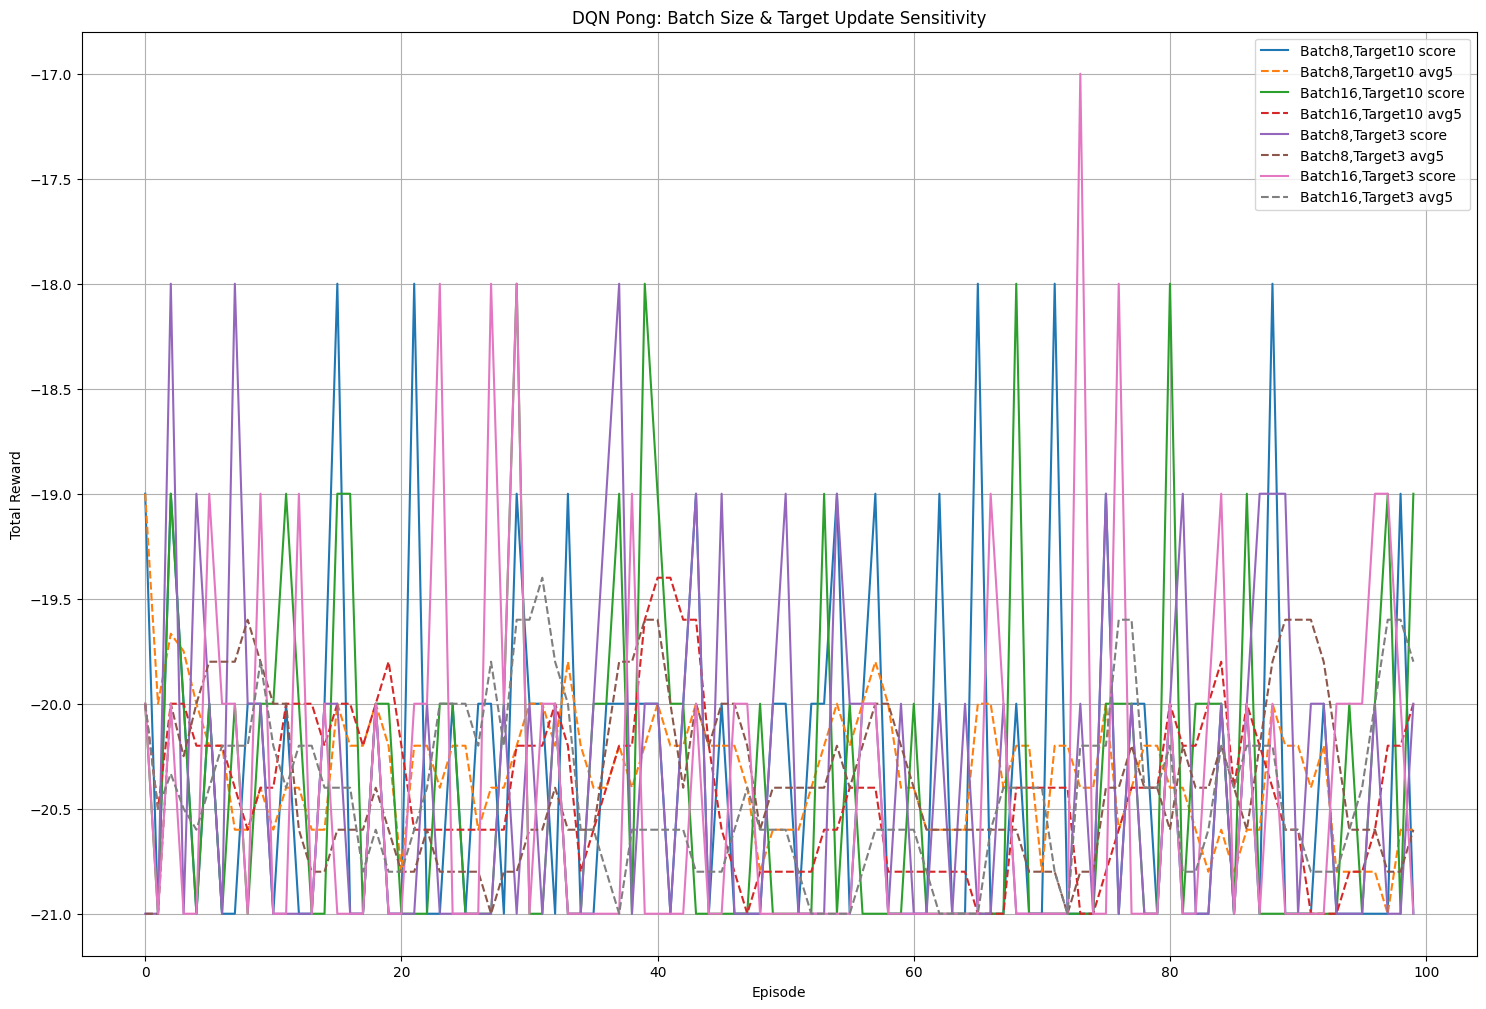

In [160]:
# Import library
import matplotlib.pyplot as plt

# Plotting results
plt.figure(figsize=(18,12))
for label, rewards in results_dict.items():
    plt.plot(rewards, label=f"{label} score")
    avg_curve = [np.mean(rewards[max(0,i-4):i+1]) for i in range(len(rewards))]
    plt.plot(avg_curve, linestyle="--", label=f"{label} avg5")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("DQN Pong: Batch Size & Target Update Sensitivity")
plt.legend()
plt.grid()
plt.show()

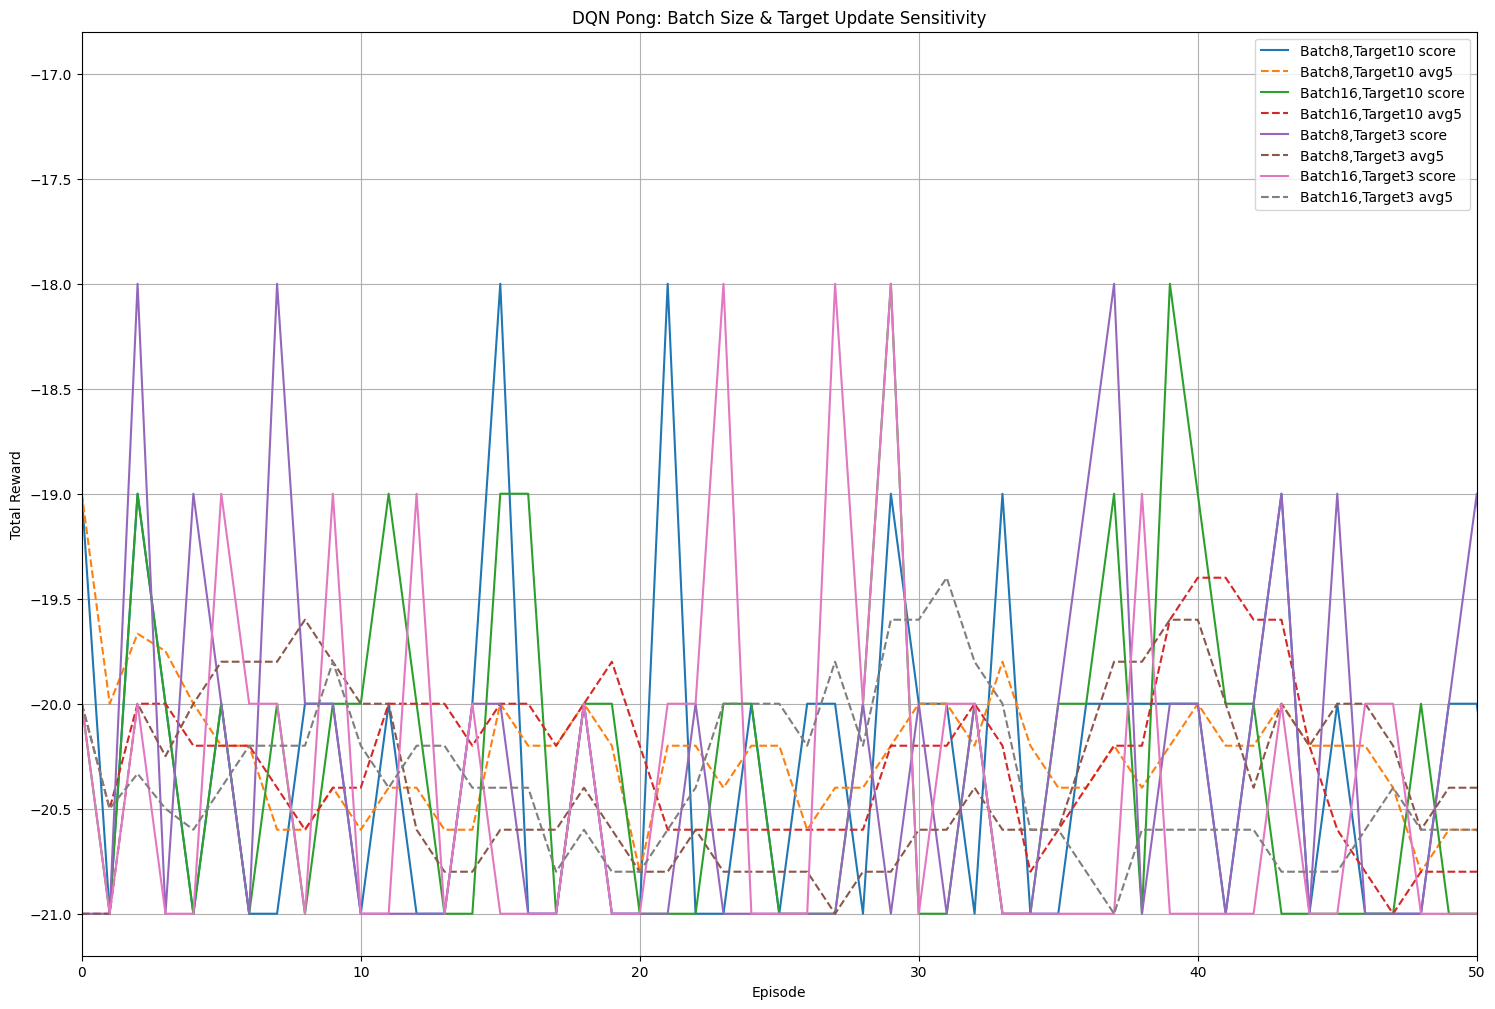

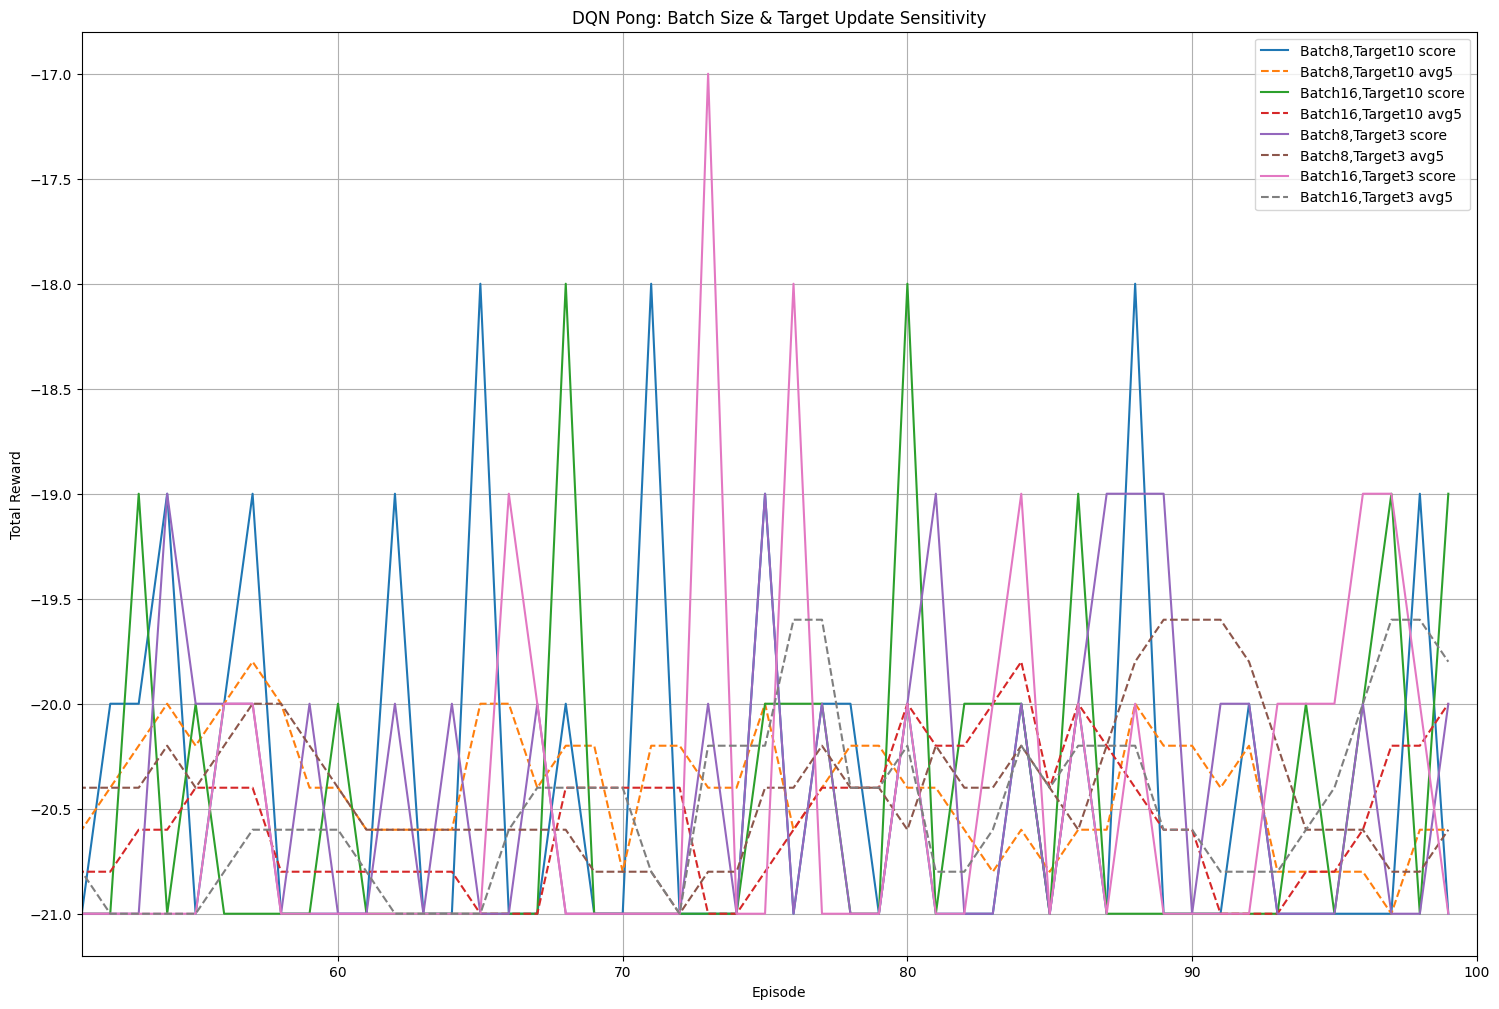

In [162]:
# Plotting results
plt.figure(figsize=(18,12))
for label, rewards in results_dict.items():
    plt.plot(rewards, label=f"{label} score")
    avg_curve = [np.mean(rewards[max(0,i-4):i+1]) for i in range(len(rewards))]
    plt.plot(avg_curve, linestyle="--", label=f"{label} avg5")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("DQN Pong: Batch Size & Target Update Sensitivity")
plt.xlim(0, 50)
plt.legend()
plt.grid()
plt.show()


# Plotting results
plt.figure(figsize=(18,12))
for label, rewards in results_dict.items():
    plt.plot(rewards, label=f"{label} score")
    avg_curve = [np.mean(rewards[max(0,i-4):i+1]) for i in range(len(rewards))]
    plt.plot(avg_curve, linestyle="--", label=f"{label} avg5")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("DQN Pong: Batch Size & Target Update Sensitivity")
plt.xlim(51, 100)
plt.legend()
plt.grid()
plt.show()

# Conclusions and Recommendations